# Import libraries

In [45]:
import os
import cv2
import tqdm
import time
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

### Other dependencies ###
from PIL import Image
from dataloader.obj_detection import DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

### Tensorflow dependencies ###
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy

### Some constants ###
input_dim = 12 # 48
# weights_dir = 'road_signs_1'
weights_dir = 'road_signs_w_dataloader'
pnet_tensorboard_logdir = '../pnet_logs'
rnet_tensorboard_logdir = '../rnet_logs'
onet_tensorboard_logdir = '../onet_logs'

pnet_weights = f'../weights/{weights_dir}/pnet.weights.hdf5'
rnet_weights = f'../weights/{weights_dir}/rnet.weights.hdf5'
onet_weights = f'../weights/{weights_dir}/onet.weights.hdf5'

if(not os.path.exists(f'../weights/{weights_dir}')):
    print('[INFO] Created weight directory ...')
    os.mkdir(f'../weights/{weights_dir}')
    
if(os.path.exists(pnet_tensorboard_logdir)):
    print('[INFO] Clearing P-Net log directory ... ')
    shutil.rmtree(pnet_tensorboard_logdir)

if(os.path.exists(rnet_tensorboard_logdir)):
    print('[INFO] Clearing R-Net log directory ... ')
    shutil.rmtree(rnet_tensorboard_logdir)

if(os.path.exists(onet_tensorboard_logdir)):
    print('[INFO] Clearing O-Net log directory ... ')
    shutil.rmtree(onet_tensorboard_logdir)
    
epochs = 100 # 500
batch_size = 16
pnet_tensorboard = TensorBoard(log_dir=pnet_tensorboard_logdir)
pnet_checkpoint = ModelCheckpoint(pnet_weights, save_weights_only=True)
pnet_callbacks = [pnet_tensorboard, pnet_checkpoint]

rnet_tensorboard = TensorBoard(log_dir=rnet_tensorboard_logdir)
rnet_checkpoint = ModelCheckpoint(rnet_weights, save_weights_only=True)
rnet_callbacks = [rnet_tensorboard, rnet_checkpoint]

onet_tensorboard = TensorBoard(log_dir=onet_tensorboard_logdir)
onet_checkpoint = ModelCheckpoint(onet_weights, save_weights_only=True)
onet_early_stop1 = EarlyStopping(monitor='val_probability_loss', patience=15, verbose=1)
onet_early_stop2 = EarlyStopping(monitor='val_bbox_regression_loss', patience=15, verbose=1)
onet_callbacks = [onet_tensorboard, onet_checkpoint]

train_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSRB/outputs/train"
test_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSRB/outputs/test"

# Load and explore dataset

In [2]:
### Creating the train loader ###
train_loader = DataLoader(train_dir, format_='darknet', 
                    color_space='rgb', img_size=input_dim, batch_size=64,
                   crop_to_bounding_box=False)

### Creating the test loader ###
test_loader = DataLoader(test_dir, format_='darknet', 
                    color_space='rgb', img_size=input_dim, batch_size=64,
                   crop_to_bounding_box=False)

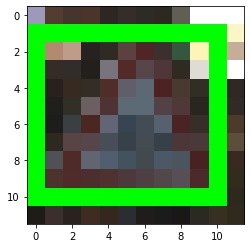

In [3]:
train_dataset = train_loader.get_train_dataset()
val_dataset = train_loader.get_val_dataset()

batch = next(iter(train_dataset))
img, (bbox, label) = batch
img = (img.numpy()[0] * 127.5 + 127.5).astype('uint8')
H, W = img.shape[:2]
x, y, w, h = (bbox.numpy()[0] * np.array([W, H, W, H])).astype('int')
img = cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)

plt.imshow(img)
plt.show()

# Implement P-Net architecture

In [4]:
def conv_block(in_filters, out_filters, kernel_size=3, batch_norm=False):
    inputs = Input(shape=(None, None, in_filters))
    p_layer = Conv2D(out_filters, kernel_size=kernel_size, strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
        
    p_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(p_layer)
    
    block = Model(inputs = inputs, outputs=p_layer)
    return block

def build_pnet_model(input_shape=None, batch_norm=True, dropout=False, n_classes=2, activation='relu'):
    if(input_shape is not None):
        if(input_shape not in [12, 24, 48, 112, 224]):
            raise Exception('Input shape must be in 12, 24, 48')
    
    inputs = Input(shape=(None, None, 3))
    p_layer = conv_block(3, 10, kernel_size=3, batch_norm=batch_norm)(inputs)
    
    if(input_shape is not None):
        if(input_shape >= 24):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)
    
    if(input_shape is not None):
        if(input_shape >= 48):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)
            
    if(input_shape is not None):
        if(input_shape >= 112):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)

    p_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
        
    p_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(dropout) : p_layer = Dropout(0.5)(p_layer)

    p_layer_out1 = Conv2D(n_classes, kernel_size=(1, 1), strides=(2, 2))(p_layer)
    p_layer_out1 = Softmax(axis=3, name='probability')(p_layer_out1)
    p_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(2, 2), activation='sigmoid', name='bbox_regression')(p_layer)

    p_net = Model(inputs, [p_layer_out1, p_layer_out2], name='P-Net')

    return p_net


### GIoU formula ###
def GIoU(bboxes_1, bboxes_2, regularization=False):
    # 1. calulate intersection over union
    area_1 = (bboxes_1[..., 2] - bboxes_1[..., 0]) * (bboxes_1[..., 3] - bboxes_1[..., 1])
    area_2 = (bboxes_2[..., 2] - bboxes_2[..., 0]) * (bboxes_2[..., 3] - bboxes_2[..., 1])
    
    intersection_wh = tf.minimum(bboxes_1[:, :, 2:], bboxes_2[:, :, 2:]) - tf.maximum(bboxes_1[:, :, :2], bboxes_2[:, :, :2])
    intersection_wh = tf.maximum(intersection_wh, 0)
    
    intersection = intersection_wh[..., 0] * intersection_wh[..., 1]
    union = (area_1 + area_2) - intersection
    
    ious = intersection / tf.maximum(union, 1e-10)

    # 2. (C - (A U B))/C
    C_wh = tf.maximum(bboxes_1[..., 2:], bboxes_2[..., 2:]) - tf.minimum(bboxes_1[..., :2], bboxes_2[..., :2])
    C_wh = tf.maximum(C_wh, 0.0)
    C = C_wh[..., 0] * C_wh[..., 1]
    
    # 3. Additional regularization - to preserve aspect ratio
    lambda_ = 2e-4
    w_reg = lambda_ * K.binary_crossentropy(bboxes_1[..., 2], bboxes_2[...,2])
    h_reg = lambda_ * K.binary_crossentropy(bboxes_1[..., 3], bboxes_2[...,3])
    
    giou = ious - (C - union) / tf.maximum(C, 1e-10)
    if(regularization):
        giou += 0.5 * (w_reg + h_reg)
        
    return giou 

n_classes = train_loader.n_classes
pnet = build_pnet_model(input_shape=input_dim, batch_norm=True, dropout=True,
                        n_classes=n_classes)

prob, bbox = pnet(tf.random.normal((1,12,12,3)))
print(bbox.shape, prob.shape)
print(pnet.summary())

(1, 1, 1, 4) (1, 1, 1, 43)
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, None, None, 1 330         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 1456        functional_1[0][0]               
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, None, None, 1 16          conv2d_1[0][0]                   
___________________________________________________________________

# Start training P-Net

In [5]:
losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() # MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)
}

if(os.path.exists(pnet_weights)):
    print('[INFO] Loading P-Net pretrained weights ...')
    pnet.load_weights(pnet_weights)
pnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

In [6]:
# history = pnet.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset, callbacks=pnet_callbacks)

steps_per_epoch = train_loader.dataset_len
validation_steps = train_loader.val_len
bce  = CategoricalCrossentropy(from_logits=False) # BinaryCrossentropy(from_logits=False)
giou = tfa.losses.GIoULoss()
opt = Adam(lr=0.0001, amsgrad=True)
accuracy = tf.keras.metrics.Accuracy()

@tf.function
def train_step(model, batch):
    with tf.GradientTape() as tape:
        img, (bbox, prob) = batch
        bbox = tf.expand_dims(bbox, axis=1)
        bbox = tf.expand_dims(bbox, axis=1)
        prob = tf.expand_dims(prob, axis=1)
        prob = tf.expand_dims(prob, axis=1)
        prob = tf.one_hot(prob, depth=n_classes)
        pr_prob, pr_bbox = model(img, training=True)
        
        # print(pr_prob.shape, prob.shape)
        # print(pr_bbox.shape, bbox.shape)
        cls_loss = bce(prob, pr_prob)
        bbx_loss = giou(bbox, pr_bbox)
        
        loss = cls_loss + bbx_loss
        
        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        
    return cls_loss, bbx_loss

@tf.function
def validation_step(model, batch):
    img, (bbox, prob) = batch
    bbox = tf.expand_dims(bbox, axis=1)
    bbox = tf.expand_dims(bbox, axis=1)
    prob = tf.expand_dims(prob, axis=1)
    prob = tf.expand_dims(prob, axis=1)
    prob = tf.one_hot(prob, depth=n_classes)
    pr_prob, pr_bbox = model(img, training=False)
    
    bbx_loss = giou(bbox, pr_bbox)
    cls_loss = bce(prob, pr_prob)
    acc = accuracy(tf.math.argmax(prob, axis=3), tf.math.argmax(pr_prob, axis=3))
    
    return cls_loss, bbx_loss, acc
        
def train(model, dataset, val_dataset, weights_file, steps_per_epoch=1000, validation_steps=100, epochs=100):
    for i in range(epochs):
        print(f'Epoch {i+1}/{epochs}')
        with tqdm.tqdm(total=steps_per_epoch) as pbar:
            for j in range(steps_per_epoch):
                batch = next(iter(dataset))

                cls_loss, bbox_loss = train_step(model, batch)
                cls_loss = cls_loss.numpy()
                bbox_loss = bbox_loss.numpy()

                # if((j + 1) % 100 == 0):
                #     print(f'[*] Batch #{j+1}, Epoch #{i+1}: Classification loss = {cls_loss:.4f}, BBox loss = {bbox_loss:.4f}')
                
                pbar.set_postfix({
                    'batch_id' : j+1,
                    'cls_loss': f'{cls_loss:.4f}',
                    'bbox_loss' : f'{bbox_loss:.4f}'
                })
                pbar.update(1)
                
        print('Saving model weights ... ')
        model.save_weights(weights_file)
        print('Validating ... ')
        with tqdm.tqdm(total=validation_steps) as pbar:
            for j in range(validation_steps):
                batch = next(iter(val_dataset))
                cls_loss, bbox_loss, acc = validation_step(model, batch)

                pbar.set_postfix({
                    'batch_id' : j + 1,
                    'cls_loss' : f'{cls_loss:.4f}',
                    'bbox_loss' : f'{bbox_loss:.4f}',
                    'accuracy' : f'{acc:.2f}'
                })
                pbar.update(1)
    
train(pnet, train_dataset, val_dataset, pnet_weights, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=40)
    

print('[INFO] Training halted, plotting training history ... ')

# history = history.history
# fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# ax[0].plot(history['probability_loss'], color='orange', label='Training')
# ax[0].plot(history['val_probability_loss'], color='blue', label='Validation')

# ax[1].plot(history['bbox_regression_loss'], color='orange', label='Training')
# ax[1].plot(history['val_bbox_regression_loss'], color='blue', label='Validation')

# ax[0].legend()
# ax[0].set_title('Classification losses')

# ax[1].legend()
# ax[1].set_title('BBox regression losses')

# plt.savefig('PNet_training_result.png')
# plt.show()

  0%|          | 0/612 [00:00<?, ?it/s]

Epoch 1/40


  0%|          | 0/612 [00:00<?, ?it/s]

Validating ... 


  0%|          | 1/612 [00:00<01:01,  9.99it/s, batch_id=1, cls_loss=3.4781, bbox_loss=0.4707]

Epoch 2/40


  0%|          | 2/612 [00:00<00:59, 10.22it/s, batch_id=2, cls_loss=3.1652, bbox_loss=0.2945, accuracy=0.1252]

Validating ... 


  0%|          | 1/612 [00:00<01:03,  9.63it/s, batch_id=1, cls_loss=3.2848, bbox_loss=0.4438]

Epoch 3/40


  0%|          | 2/612 [00:00<00:58, 10.51it/s, batch_id=2, cls_loss=2.8791, bbox_loss=0.2903, accuracy=0.1992]

Validating ... 


  0%|          | 1/612 [00:00<01:04,  9.55it/s, batch_id=1, cls_loss=2.8979, bbox_loss=0.4255]

Epoch 4/40


  0%|          | 2/612 [00:00<00:58, 10.43it/s, batch_id=2, cls_loss=2.4413, bbox_loss=0.3384, accuracy=0.2532]

Validating ... 


  0%|          | 1/612 [00:00<01:03,  9.59it/s, batch_id=1, cls_loss=2.7976, bbox_loss=0.3707]

Epoch 5/40


  0%|          | 2/612 [00:00<00:58, 10.41it/s, batch_id=2, cls_loss=2.0774, bbox_loss=0.3580, accuracy=0.2968]

Validating ... 


 42%|████▏     | 257/612 [00:25<00:35, 10.02it/s, batch_id=257, cls_loss=2.1609, bbox_loss=0.3150, accuracy=0.3131]


KeyboardInterrupt: 

# Start training R-Net

In [ ]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=5, crop_size=(input_dim*2,input_dim*2))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(10, 30), frame_per_img=4, img_size=input_dim*2)
pos_samples[:, 2] = 1.0
# pos_samples[:,2] = LabelEncoder().fit_transform(pos_samples[:, 2])
# pos_samples[:,2] += 1

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() 
    # 'bbox_regression' : MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

rnet = build_pnet_model(input_shape=input_dim*2, batch_norm=True, dropout=True, n_classes=n_classes)
print(rnet.summary())

if(os.path.exists(rnet_weights)):
    print('[INFO] Loading R-Net pretrained weights ...')
    rnet.load_weights(rnet_weights)

rnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

history = rnet.fit(train_images, y, epochs=epochs, batch_size=batch_size, callbacks=rnet_callbacks, validation_split=0.2)
print('[INFO] Training halted, plotting training history ... ')

history = history.history
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history['probability_loss'], color='orange', label='Training')
ax[0].plot(history['val_probability_loss'], color='blue', label='Validation')
""
ax[1].plot(history['bbox_regression_loss'], color='orange', label='Training')
ax[1].plot(history['val_bbox_regression_loss'], color='blue', label='Validation')

ax[0].legend()
ax[0].set_title('Classification losses')

ax[1].legend()
ax[1].set_title('BBox regression losses')

plt.savefig('RNet_training_result.png')
plt.show()

# Training O-Net

In [ ]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=4, crop_size=(input_dim*4,input_dim*4))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(10, 30), frame_per_img=4, img_size=input_dim*4)
pos_samples[:, 2] = 1.0

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() 
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

onet = build_pnet_model(input_shape=input_dim*4, batch_norm=True, dropout=True, n_classes=n_classes)
print(onet.summary())

if(os.path.exists(onet_weights)):
    print('[INFO] Loading O-Net pretrained weights ...')
    onet.load_weights(onet_weights)
onet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

history = onet.fit(train_images, y, epochs=epochs, validation_split=0.2, batch_size=batch_size, callbacks=onet_callbacks)
print('[INFO] Training halted, plotting training history ... ')

history = history.history
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history['probability_loss'], color='orange', label='Training')
ax[0].plot(history['val_probability_loss'], color='blue', label='Validation')
""
ax[1].plot(history['bbox_regression_loss'], color='orange', label='Training')
ax[1].plot(history['val_bbox_regression_loss'], color='blue', label='Validation')

ax[0].legend()
ax[0].set_title('Classification losses')

ax[1].legend()
ax[1].set_title('BBox regression losses')

plt.savefig('ONet_training_result.png')
plt.show()

# Test P-Net proposals

In [46]:
pnet = build_pnet_model(input_shape=input_dim, batch_norm=True, dropout=True, n_classes=n_classes)
rnet = build_pnet_model(input_shape=input_dim*2, batch_norm=True, dropout=True, n_classes=n_classes)
onet = build_pnet_model(input_shape=input_dim*4, batch_norm=True, dropout=True, n_classes=n_classes)


if(os.path.exists(pnet_weights)):
    print('[INFO] Loading weights for P-Net ... ')
    pnet.load_weights(pnet_weights)

if(os.path.exists(rnet_weights)):
    print('[INFO] Loading weights for R-Net ... ')
    rnet.load_weights(rnet_weights)

if(os.path.exists(onet_weights)):
    print('[INFO] Loading weights for o-Net ... ')
    onet.load_weights(onet_weights)
    
def __nms(boxes, s, threshold, method):
    """
        Non Maximum Suppression.

        Params:
            @param boxes: np array with bounding boxes.
            @param threshold:
            @param method: NMS method to apply. Available values ('Min', 'Union')
        
        Return:
            pick : An array of indices selected.
    """
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_s = np.argsort(s)

    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while sorted_s.size > 0:
        i = sorted_s[-1]
        pick[counter] = i
        counter += 1
        idx = sorted_s[0:-1]

        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h

        if method == 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)

        sorted_s = sorted_s[np.where(o <= threshold)]

    pick = pick[0:counter]

    return pick

[INFO] Loading weights for P-Net ... 
[INFO] Loading weights for R-Net ... 
[INFO] Loading weights for o-Net ... 


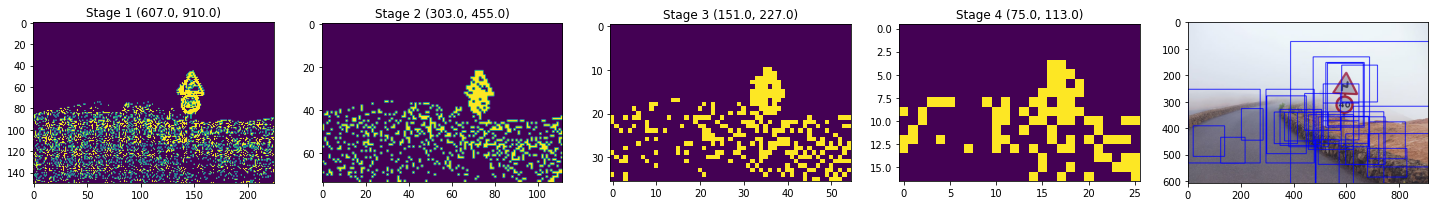

In [47]:
# raw_img = cv2.imread(os.path.join(train_dir, 'road155.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road198.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road202.png')) # --> True but quite abit of overlapping boxes
# raw_img = cv2.imread(os.path.join(train_dir, 'road215.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road797.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road655.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road420.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road123.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road109.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road108.png')) # --> False, target too small
# raw_img = cv2.imread(os.path.join(train_dir, 'road99.png')) # --> Very true
# raw_img = cv2.imread(os.path.join(train_dir, 'road90.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road282.png')) # --> False, too blurry
# raw_img = cv2.imread(os.path.join(train_dir, 'road282.png')) # --> False, too blurry
# raw_img = cv2.imread(os.path.join(train_dir, 'road147.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road585.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road595.png'))
raw_img = cv2.imread('test/test4.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

def get_bboxes_pnet(raw_img, threshold=0.5, nms_threshold=0.5,
                    scale_factor=2.0, min_img_size = 48, padding = 0.15, visualize=False):
    '''
        
    '''
    H, W = raw_img.shape[:2]
    images = [raw_img]
    current_h, current_w = raw_img.shape[:2]
    
    ### 1. Get image pyramid ###
    while(current_h > min_img_size and current_w > min_img_size):
        current_h = int(current_h / scale_factor)
        current_w = int(current_w / scale_factor)

        if(current_w < min_img_size or current_h < min_img_size) : break

        image = cv2.resize(raw_img, (current_w, current_h))
        images.append(image)

    ### 2. Get bounding boxes from each image in the pyramid ###
    boxes = []
    conf_maps_viz = []
    for i, image in enumerate(images):
        if(i == 0): scale = 1
        else : scale = scale_factor ** i

        img = (image - 127.5) / 127.5
        height, width = image.shape[:2]

        predictions = pnet.predict(np.array([img]))
        features_shape = predictions[1][0].shape[:2]

        scale_w = width / features_shape[1]
        scale_h = height / features_shape[0]

        bboxes = predictions[1][0]
        raw_bboxes = bboxes
        confidence = predictions[0][0]

        ### Getting confidence map ###
        conf_map = np.max(confidence[:, :, :], axis=2)
        # conf_map = confidence[:,:,1]
        conf_map[conf_map > threshold] = 1.0
        conf_map[conf_map <= threshold] = 0
        conf_map = (conf_map * 255).astype(np.uint8)
        contours, hierarchy = cv2.findContours(conf_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        conf_maps_viz.append(conf_map)
        
        for contour in contours:
            rect = cv2.boundingRect(contour)
            x, y, w, h = (rect * np.array([W/conf_map.shape[1],H/conf_map.shape[0],W/conf_map.shape[1],H/conf_map.shape[0] ])).astype(int)

            x -= min(int(padding * w), x)
            y -= min(int(padding * h), y)
            w += 2*int(padding * w)
            h += 2*int(padding * h)
            if(w * h < (W * H)/64): continue
            boxes.append([x,y,w,h])
    
    ### Performing nms ###
    final_boxes = []
    pick = __nms(np.array(boxes), np.ones((len(boxes))), nms_threshold, 'Min')
    for i in range(len(boxes)):
        final_boxes.append(boxes[i])
        
    crops = []
    if(visualize):
        fig, ax = plt.subplots(1, len(conf_maps_viz) + 1, figsize=(5*(len(conf_maps_viz) + 1), 5))
        for i in range(len(conf_maps_viz)):
            current_size = (H // (scale_factor ** i),W // (scale_factor**i))
            ax[i].imshow(conf_maps_viz[i])
            ax[i].set_title(f'Stage {i+1} {current_size}')
        
    raw_img_copy = raw_img.copy()
    for (x, y, w, h) in final_boxes:
        cv2.rectangle(raw_img_copy, (x,y), (x+w, y+h), (0,0,255),2)
        crops.append([(x,y,w,h), raw_img[y:y+h, x:x+w]])
            
    if(visualize):
        plt.imshow(raw_img_copy)
        plt.show()
        
    return final_boxes, crops
        
boxes, crops = get_bboxes_pnet(raw_img, threshold=0.5, visualize=True)

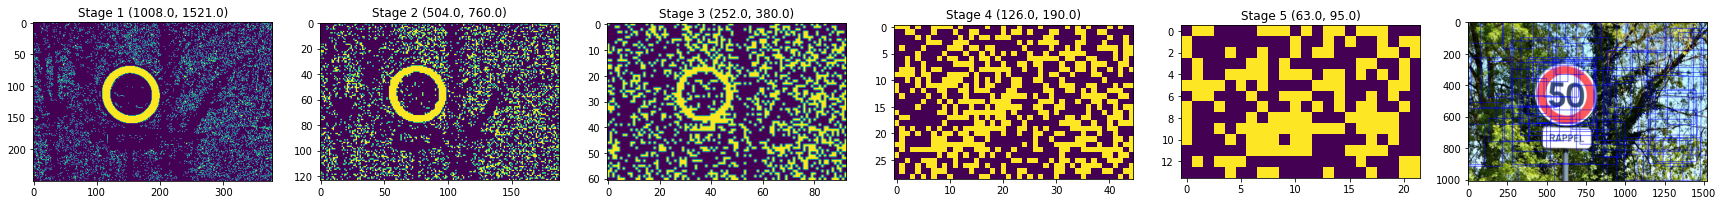

FPS : 49.84233031860202


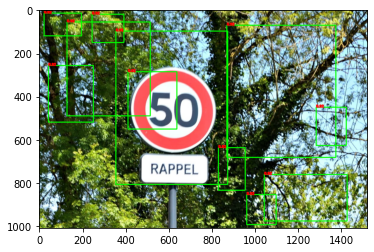

In [50]:
raw_img = cv2.imread('test/test3.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
boxes, crops = get_bboxes_pnet(raw_img, threshold=0.9, visualize=True)

raw_img_copy = raw_img.copy()
boxes = []

n_frames = 0
start = time.time()
for i in crops:
    n_frames += 1
    crop = i[1]
    (x, y, w, h) = i[0]
    H, W = crop.shape[:2]
    img = cv2.resize(crop, (input_dim*4, input_dim*4))
    img = (img - 127.5) / 127.5
    
    prediction = onet.predict(np.array([img]))
    confidence = prediction[0][0][0][0]
    
    label = np.argmax(confidence)
    confidence = confidence[np.argmax(confidence)]
    
    bbox = prediction[1][0][0][0]
    if(confidence < 0.98 or label == 0):continue
    
    x_,y_,w,h = (bbox * np.array([W, H, W, H])).astype('int')
    x+=x_
    y+=y_
    
    boxes.append([x, y, w, h])
end = time.time()
print(f'FPS : {n_frames/(end - start)}')

pick = __nms(np.array(boxes), np.ones((len(boxes))), 0.3, 'Max')
for i in pick:
    x, y, w, h = boxes[i]
    raw_img_copy = cv2.rectangle(raw_img_copy, (x, y), (x+w, y+h), (0,255,0), 3)
    raw_img_copy = cv2.putText(raw_img_copy, f'{confidence:.2f}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 3)
    
plt.imshow(raw_img_copy)
plt.show()